## **What is LSTMs ?**

Long Short Term Memory networks, or "LSTMs," are a type of RNN that can learn long-term dependencies. Hochreiter & Schmidhuber (1997) introduced them, and numerous individuals developed and popularised them in subsequent work. 1 They are currently frequently utilised and function exceptionally effectively on a wide range of situations.

LSTMs are specifically developed to prevent the problem of long-term dependency. They don't have to work hard to remember knowledge for lengthy periods of time; it's like second nature to them!

Recurrent neural networks all have the shape of a sequence of repeated neural network modules. In standard RNNs, this repeating module will have a very simple structure, such as a single tanh layer.

![LSTM1](Assets/LSTM1.png)

LSTMs also have this chain like structure, but the repeating module has a different structure. Instead of having a single neural network layer, there are four, interacting in a very special way.

![LSTM2](Assets/LSTM2.png) <br>

![LSTM3](Assets/LSTM3.png)

Each line in the figure above transmits a full vector from one node's output to the inputs of others. The pink circles denote pointwise operations, such as vector addition, and the yellow boxes denote learnt neural network layers. Concatenation occurs when lines merge, whereas forking occurs when a line's content is replicated and the copies are sent to various locations.

### **The Core Idea Behind LSTMs**

The cell state, the horizontal line going through the top of the diagram, is the key to LSTMs.

The state of the cell is similar to that of a conveyor belt. With only a few tiny linear interactions, it flows straight down the entire chain. It's incredibly easy for data to simply travel along it unaltered.

![LSTM4](Assets/LSTM4.png)

The LSTM can delete or add information to the cell state, which is carefully controlled by structures called gates.

Gates are a mechanism to selectively allow information to pass through. A sigmoid neural net layer plus a pointwise multiplication operation make them up.

![LSTM5](Assets/LSTM5.png)

The sigmoid layer produces integers ranging from zero to one, indicating how much of each component should be allowed to pass. "Allow nothing through!" signifies a value of zero, while "let everything through!" means a value of one.

Three of these gates are present in an LSTM to protect and govern the cell state.

So the LSTM cell contains the following components

- Forget Gate “f” ( a neural network with sigmoid)
- Candidate layer “C"(a NN with Tanh)
- Input Gate “I” ( a NN with sigmoid )
- Output Gate “O”( a NN with sigmoid)
- Hidden state “H” ( a vector )
- Memory state “C” ( a vector)

- Inputs to the LSTM cell at any step are Xt (current input) , Ht-1 (previous hidden state ) and Ct-1 (previous memory state).

- Outputs from the LSTM cell are Ht (current hidden state ) and Ct (current memory state)

## **Working of gates in LSTMs**

First, LSTM cell takes the previous memory state C<sub>t-1</sub> and does element wise multiplication with forget gate (f) to decide if  present memory state C<sub>t</sub>. If forget gate value is 0 then previous memory state is completely forgotten else f forget gate value is 1 then previous memory state is completely passed to the cell ( Remember f gate gives values between 0 and 1 ).

**C<sub>t</sub> = C<sub>t-1</sub> * f<sub>t</sub>**

Calculating the new memory state: 

**C<sub>t</sub> = C<sub>t</sub> + (I<sub>t</sub> * C\`<sub>t</sub>)**

Now, we calculate the output:

**H<sub>t</sub> = tanh(C<sub>t</sub>)**

## **Program**

Let us try a **Time Series LSTM model** 

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
import math
from sklearn.metrics import mean_squared_error

In [2]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [3]:
dataset = pd.read_csv('IBM_2006-01-01_to_2018-01-01.csv', 
                      index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [4]:
# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

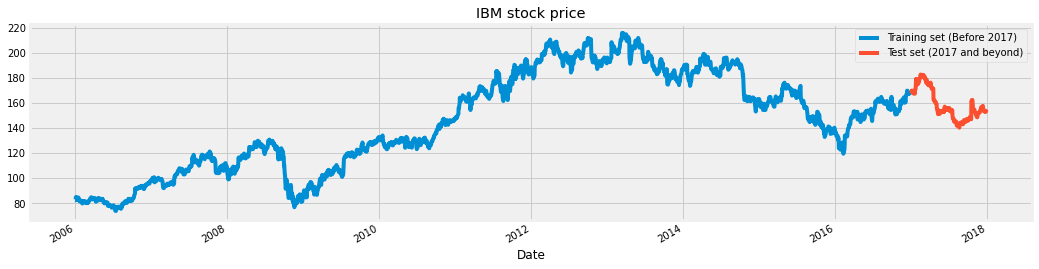

In [5]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [6]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [7]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [8]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [9]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
85/85 [==============================] - 19s 126ms/step - loss: 0.0208
Epoch 2/50
85/85 [==============================] - 11s 125ms/step - loss: 0.0096
Epoch 3/50
85/85 [==============================] - 11s 127ms/step - loss: 0.0080
Epoch 4/50
85/85 [==============================] - 11s 125ms/step - loss: 0.0067
Epoch 5/50
85/85 [==============================] - 11s 126ms/step - loss: 0.0058
Epoch 6/50
85/85 [==============================] - 11s 124ms/step - loss: 0.0051
Epoch 7/50
85/85 [==============================] - 11s 125ms/step - loss: 0.0049
Epoch 8/50
85/85 [==============================] - 11s 124ms/step - loss: 0.0046
Epoch 9/50
85/85 [==============================] - 11s 126ms/step - loss: 0.0041
Epoch 10/50
85/85 [==============================] - 11s 125ms/step - loss: 0.0037
Epoch 11/50
85/85 [==============================] - 10s 123ms/step - loss: 0.0038
Epoch 12/50
85/85 [==============================] - 11s 124ms/step - loss: 0.0035
Epoch 13/50
8

In [10]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [11]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

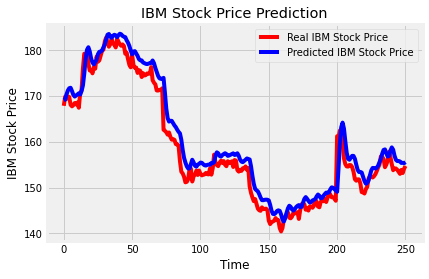

In [12]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [13]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 2.8444726356485104.


Truth be told. That's one awesome score.

## **Conclusion**

When you just look at the equations or the cell, LSTMs appear to be somewhat frightening. LSTMs are frequently utilised and quite effective. In most cases, when you hear that an RNN is being used in a specific application, it is most likely an LSTM. There is a lot of intriguing research going on with LSTMs, such as attention, Grid LSTMs, and so on.